In [3]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np

class Environment(ABC):
    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def step(self, action):
        pass

class AssetEnv(Environment):
    def __init__(self, initial_wealth=10, T=10, aversion_rate=0.01, riskless_return=0.3,
                 risky_return=None, action_space=None):
        if risky_return is None:
            risky_return = {0.4: -1.5, 0.6: 1.5}  # 概率到收益率的映射
        if action_space is None:
            action_space = [0, 1]  # 可选择的投资比例

        self.aversion_rate = aversion_rate
        self.riskless_return = riskless_return
        self.risky_return = risky_return
        self.action_space = action_space
        self.initial_wealth = initial_wealth
        self.T = T

        # 初始化状态空间和转移概率
        self.state_space = {t: set() for t in range(T+1)}
        self.state_space[0].add(initial_wealth)
        self.transition_prob = self._generate_states_and_transitions()

    def _generate_states_and_transitions(self):
        transition_dict = {}
        for t in range(self.T):
            transition_dict[t] = {}
            for wealth in self.state_space[t]:
                transition_dict[t][wealth] = {}
                for action in self.action_space:
                    transitions = []
                    # 生成所有可能的转移
                    for prob, risky_r in self.risky_return.items():
                        next_wealth = np.round(
                            wealth * (action*(1+risky_r) + (1-action)*(1+self.riskless_return)),
                            3
                        )
                        self.state_space[t+1].add(next_wealth)
                        done = (t == self.T-1)
                        reward = self.cara_reward(next_wealth) if done else 0
                        transitions.append( (prob, next_wealth, reward, done) )
                    transition_dict[t][wealth][action] = transitions
        return transition_dict

    def reset(self):
        self.current_wealth = self.initial_wealth
        self.time_step = 0
        return self.current_wealth

    def step(self, action):
        transitions = self.transition_prob[self.time_step][self.current_wealth][action]
        probs = [t[0] for t in transitions]
        idx = np.random.choice(len(transitions), p=probs)
        _, next_wealth, reward, done = transitions[idx]
        
        self.current_wealth = next_wealth
        self.time_step += 1
        return next_wealth, reward, done, {}

    def cara_reward(self, wealth):
        return  (-np.exp(- self.aversion_rate * wealth)) / self.aversion_rate

class SARSAAgent:
    def __init__(self, env, discount_factor=1, epsilon=0.8, alpha=0.7):
        self.env = env
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.alpha = alpha

        # 初始化Q表和策略
        self.Q = {}
        self.policy = {}
        for t in range(env.T):
            self.Q[t] = {}
            self.policy[t] = {}
            for wealth in env.state_space[t]:
                self.Q[t][wealth] = {a: 0.0 for a in env.action_space}
                self.policy[t][wealth] = self._init_policy(env.action_space)

    def _init_policy(self, actions):
        """ 初始化均匀随机策略 """
        return {a: 1/len(actions) for a in actions}

    def _update_policy(self, t, wealth):
        """ 使用ε-greedy策略更新 """
        best_action = max(self.Q[t][wealth], key=self.Q[t][wealth].get)
        for a in self.policy[t][wealth]:
            if a == best_action:
                self.policy[t][wealth][a] = 1 - self.epsilon + self.epsilon/len(self.env.action_space)
            else:
                self.policy[t][wealth][a] = self.epsilon/len(self.env.action_space)

    def choose_action(self, t, wealth):
        return np.random.choice(
            list(self.policy[t][wealth].keys()),
            p=list(self.policy[t][wealth].values())
        )

    def train(self, episodes=10000):
        for _ in range(episodes):
            wealth = self.env.reset()
            t = 0
            action = self.choose_action(t, wealth)
            done = False

            while not done:
                next_wealth, reward, done, _ = self.env.step(action)
                
                if done:
                    # 终止状态的更新
                    td_target = reward
                    self.Q[t][wealth][action] += self.alpha * (td_target - self.Q[t][wealth][action])
                    self._update_policy(t, wealth)
                    break
                
                # 选择下一个动作
                next_action = self.choose_action(t+1, next_wealth)
                
                # SARSA更新
                td_target = reward + self.gamma * self.Q[t+1][next_wealth][next_action]
                self.Q[t][wealth][action] += self.alpha * (td_target - self.Q[t][wealth][action])
                
                # 更新策略
                self._update_policy(t, wealth)
                
                # 转移到下一个状态
                wealth, action, t = next_wealth, next_action, t+1

        return self.Q, self.policy



Time 0:
  Wealth 10.00: Best Action 0
Time 1:
  Wealth 10.10: Best Action 0
  Wealth 10.20: Best Action 0
  Wealth 20.00: Best Action 0
Time 2:
  Wealth 10.20: Best Action 0
  Wealth 10.30: Best Action 0
  Wealth 10.40: Best Action 0
  Wealth 20.20: Best Action 0
  Wealth 20.40: Best Action 0
  Wealth 40.00: Best Action 0
Time 3:
  Wealth 10.30: Best Action 0
  Wealth 10.40: Best Action 0
  Wealth 10.51: Best Action 0
  Wealth 10.61: Best Action 0
  Wealth 20.40: Best Action 0
  Wealth 20.60: Best Action 0
  Wealth 20.81: Best Action 0
  Wealth 40.40: Best Action 0
  Wealth 40.80: Best Action 1
  Wealth 80.00: Best Action 1
Time 4:
  Wealth 10.41: Best Action 0
  Wealth 10.51: Best Action 0
  Wealth 10.61: Best Action 0
  Wealth 10.72: Best Action 0
  Wealth 10.82: Best Action 0
  Wealth 20.61: Best Action 0
  Wealth 20.81: Best Action 1
  Wealth 21.02: Best Action 0
  Wealth 21.22: Best Action 0
  Wealth 40.80: Best Action 0
  Wealth 41.21: Best Action 0
  Wealth 41.62: Best Action 0


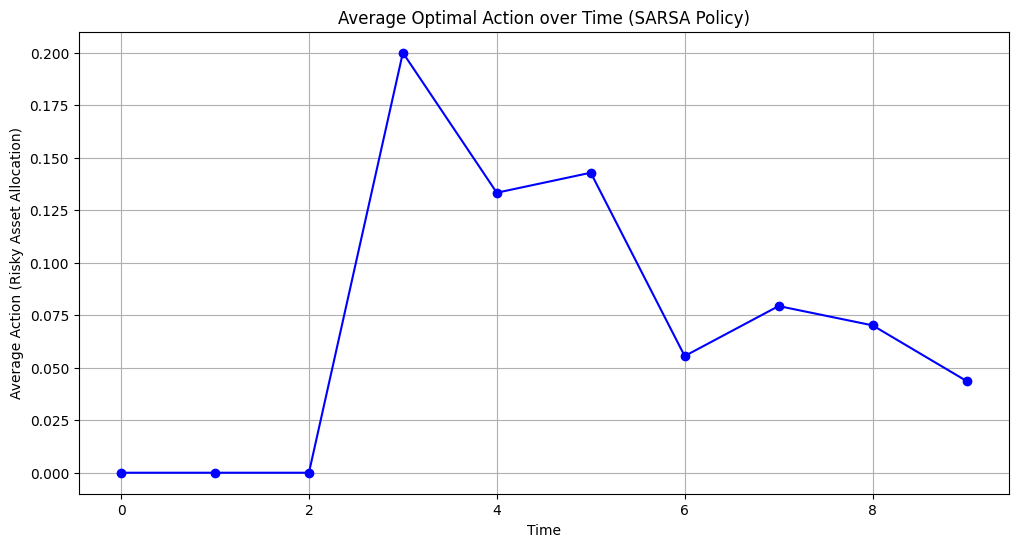

In [ ]:
"""
Test Begin，测试以下几个情况
1.riskless return远高于risky return时，我们选择的策略的平均值，0是指选择riskless，1是指选择risky资产，最后返回的是
不同时间T下的均值，并且我们输出了不同的迭代次数下的情况
2.risky return远高于riskless return
3.二者相近
"""
# 1.1 100次迭代

env = AssetEnv(initial_wealth=10, T=10, aversion_rate=0.01, riskless_return=1,
                  risky_return = {0.4: 0.01, 0.6: 0.02}, action_space=None)
agent = SARSAAgent(env)
Q, policy = agent.train(episodes=100)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()


Time 0:
  Wealth 10.00: Best Action 0
Time 1:
  Wealth 10.10: Best Action 0
  Wealth 10.20: Best Action 0
  Wealth 20.00: Best Action 0
Time 2:
  Wealth 10.20: Best Action 0
  Wealth 10.30: Best Action 0
  Wealth 10.40: Best Action 1
  Wealth 20.20: Best Action 1
  Wealth 20.40: Best Action 0
  Wealth 40.00: Best Action 0
Time 3:
  Wealth 10.30: Best Action 0
  Wealth 10.40: Best Action 0
  Wealth 10.51: Best Action 1
  Wealth 10.61: Best Action 1
  Wealth 20.40: Best Action 0
  Wealth 20.60: Best Action 0
  Wealth 20.81: Best Action 0
  Wealth 40.40: Best Action 0
  Wealth 40.80: Best Action 1
  Wealth 80.00: Best Action 0
Time 4:
  Wealth 10.41: Best Action 0
  Wealth 10.51: Best Action 1
  Wealth 10.61: Best Action 0
  Wealth 10.72: Best Action 0
  Wealth 10.82: Best Action 1
  Wealth 20.61: Best Action 0
  Wealth 20.81: Best Action 0
  Wealth 21.02: Best Action 0
  Wealth 21.22: Best Action 1
  Wealth 40.80: Best Action 0
  Wealth 41.21: Best Action 0
  Wealth 41.62: Best Action 0


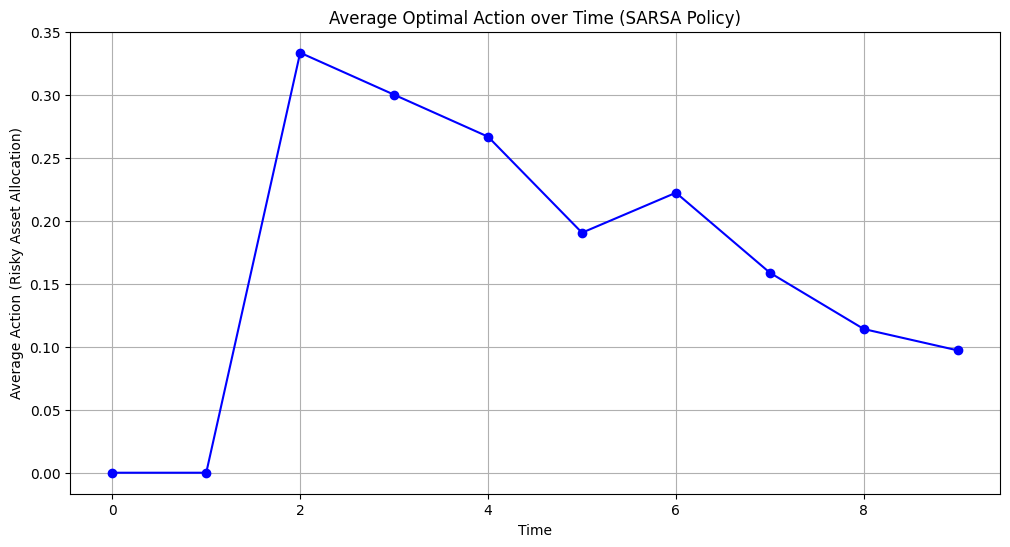

In [5]:
# 1.2 10000次迭代
Q, policy = agent.train(episodes=10000)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 0
Time 1:
  Wealth 10.10: Best Action 0
  Wealth 10.20: Best Action 0
  Wealth 20.00: Best Action 0
Time 2:
  Wealth 10.20: Best Action 0
  Wealth 10.30: Best Action 0
  Wealth 10.40: Best Action 0
  Wealth 20.20: Best Action 1
  Wealth 20.40: Best Action 0
  Wealth 40.00: Best Action 0
Time 3:
  Wealth 10.30: Best Action 0
  Wealth 10.40: Best Action 1
  Wealth 10.51: Best Action 0
  Wealth 10.61: Best Action 0
  Wealth 20.40: Best Action 0
  Wealth 20.60: Best Action 0
  Wealth 20.81: Best Action 1
  Wealth 40.40: Best Action 0
  Wealth 40.80: Best Action 0
  Wealth 80.00: Best Action 0
Time 4:
  Wealth 10.41: Best Action 0
  Wealth 10.51: Best Action 1
  Wealth 10.61: Best Action 0
  Wealth 10.72: Best Action 0
  Wealth 10.82: Best Action 0
  Wealth 20.61: Best Action 0
  Wealth 20.81: Best Action 0
  Wealth 21.02: Best Action 0
  Wealth 21.22: Best Action 0
  Wealth 40.80: Best Action 0
  Wealth 41.21: Best Action 0
  Wealth 41.62: Best Action 1


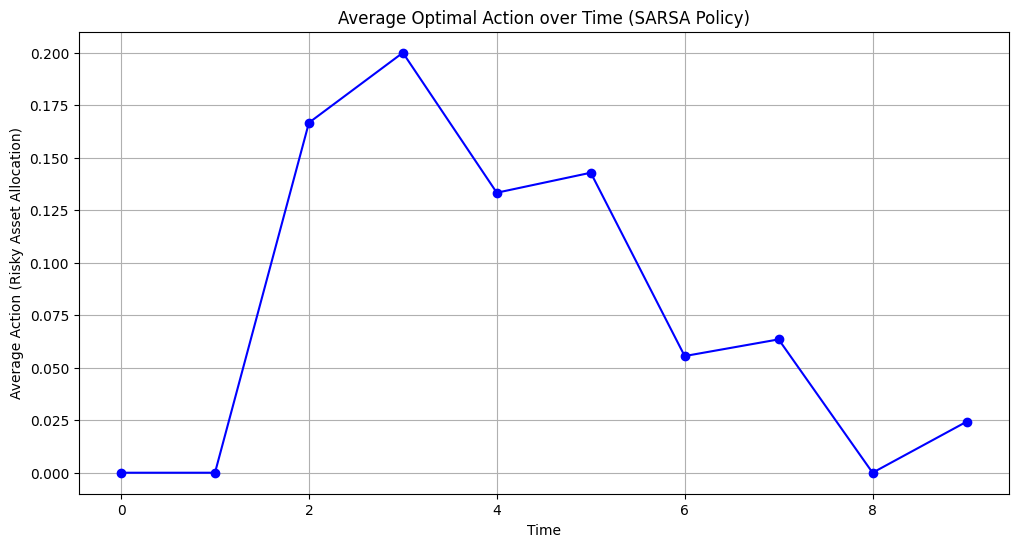

In [6]:
# 1.3:1000000次迭代
Q, policy = agent.train(episodes=1000000)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 0
Time 1:
  Wealth 10.10: Best Action 0
  Wealth 15.00: Best Action 0
  Wealth 16.00: Best Action 0
Time 2:
  Wealth 10.20: Best Action 0
  Wealth 15.15: Best Action 0
  Wealth 16.16: Best Action 0
  Wealth 22.50: Best Action 0
  Wealth 24.00: Best Action 0
  Wealth 25.60: Best Action 0
Time 3:
  Wealth 10.30: Best Action 0
  Wealth 15.30: Best Action 0
  Wealth 16.32: Best Action 0
  Wealth 22.73: Best Action 0
  Wealth 24.24: Best Action 0
  Wealth 25.86: Best Action 0
  Wealth 33.75: Best Action 0
  Wealth 36.00: Best Action 0
  Wealth 38.40: Best Action 0
  Wealth 40.96: Best Action 0
Time 4:
  Wealth 10.41: Best Action 0
  Wealth 15.46: Best Action 0
  Wealth 16.48: Best Action 0
  Wealth 22.95: Best Action 0
  Wealth 22.95: Best Action 0
  Wealth 24.48: Best Action 0
  Wealth 24.48: Best Action 0
  Wealth 26.11: Best Action 0
  Wealth 34.09: Best Action 0
  Wealth 36.36: Best Action 0
  Wealth 38.78: Best Action 0
  Wealth 41.37: Best Action 0


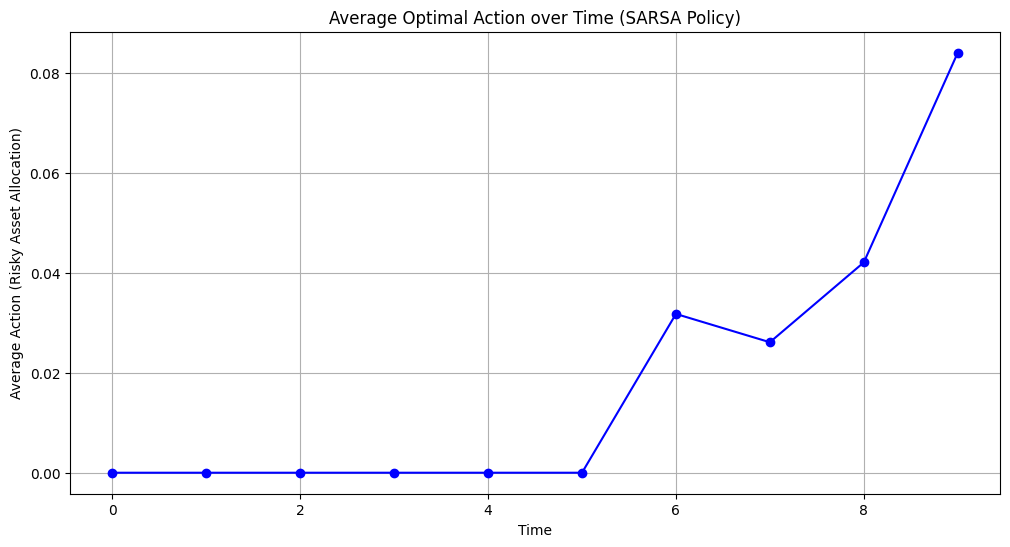

In [9]:
# 2.1 100次迭代

env = AssetEnv(initial_wealth=10, T=10, aversion_rate=0.01, riskless_return=0.01,
                  risky_return = {0.4: 0.5, 0.6: 0.6}, action_space=None)
agent = SARSAAgent(env)
Q, policy = agent.train(episodes=100)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 1
Time 1:
  Wealth 10.10: Best Action 1
  Wealth 15.00: Best Action 1
  Wealth 16.00: Best Action 1
Time 2:
  Wealth 10.20: Best Action 1
  Wealth 15.15: Best Action 1
  Wealth 16.16: Best Action 1
  Wealth 22.50: Best Action 0
  Wealth 24.00: Best Action 1
  Wealth 25.60: Best Action 1
Time 3:
  Wealth 10.30: Best Action 1
  Wealth 15.30: Best Action 1
  Wealth 16.32: Best Action 1
  Wealth 22.73: Best Action 1
  Wealth 24.24: Best Action 1
  Wealth 25.86: Best Action 1
  Wealth 33.75: Best Action 1
  Wealth 36.00: Best Action 1
  Wealth 38.40: Best Action 1
  Wealth 40.96: Best Action 1
Time 4:
  Wealth 10.41: Best Action 1
  Wealth 15.46: Best Action 1
  Wealth 16.48: Best Action 1
  Wealth 22.95: Best Action 1
  Wealth 22.95: Best Action 1
  Wealth 24.48: Best Action 1
  Wealth 24.48: Best Action 1
  Wealth 26.11: Best Action 1
  Wealth 34.09: Best Action 1
  Wealth 36.36: Best Action 1
  Wealth 38.78: Best Action 1
  Wealth 41.37: Best Action 1


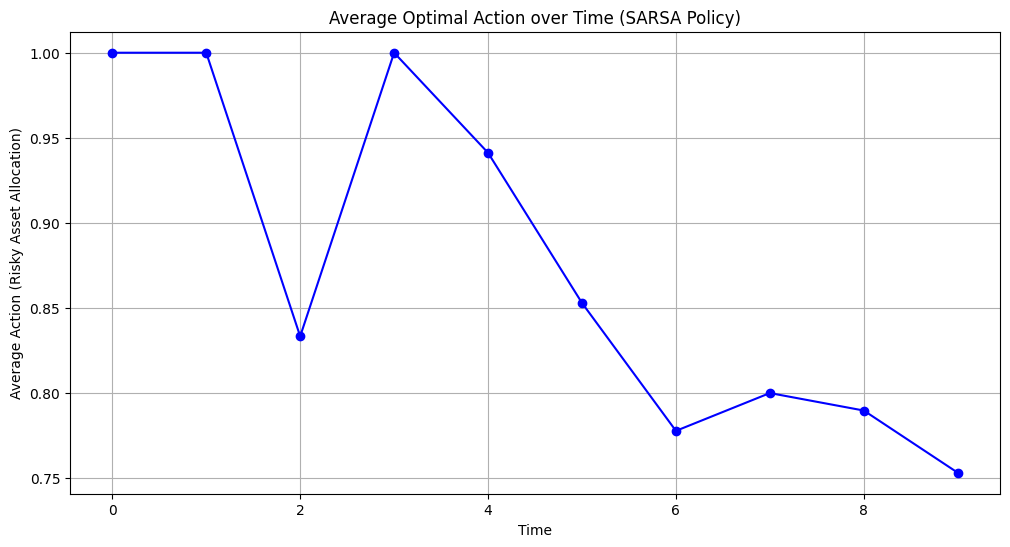

In [10]:
# 2.2 10000次迭代
Q, policy = agent.train(episodes=10000)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 1
Time 1:
  Wealth 10.10: Best Action 1
  Wealth 15.00: Best Action 1
  Wealth 16.00: Best Action 1
Time 2:
  Wealth 10.20: Best Action 1
  Wealth 15.15: Best Action 1
  Wealth 16.16: Best Action 0
  Wealth 22.50: Best Action 1
  Wealth 24.00: Best Action 1
  Wealth 25.60: Best Action 1
Time 3:
  Wealth 10.30: Best Action 1
  Wealth 15.30: Best Action 1
  Wealth 16.32: Best Action 1
  Wealth 22.73: Best Action 1
  Wealth 24.24: Best Action 1
  Wealth 25.86: Best Action 1
  Wealth 33.75: Best Action 1
  Wealth 36.00: Best Action 0
  Wealth 38.40: Best Action 1
  Wealth 40.96: Best Action 1
Time 4:
  Wealth 10.41: Best Action 1
  Wealth 15.46: Best Action 1
  Wealth 16.48: Best Action 1
  Wealth 22.95: Best Action 1
  Wealth 22.95: Best Action 1
  Wealth 24.48: Best Action 1
  Wealth 24.48: Best Action 1
  Wealth 26.11: Best Action 1
  Wealth 34.09: Best Action 1
  Wealth 36.36: Best Action 1
  Wealth 38.78: Best Action 0
  Wealth 41.37: Best Action 1


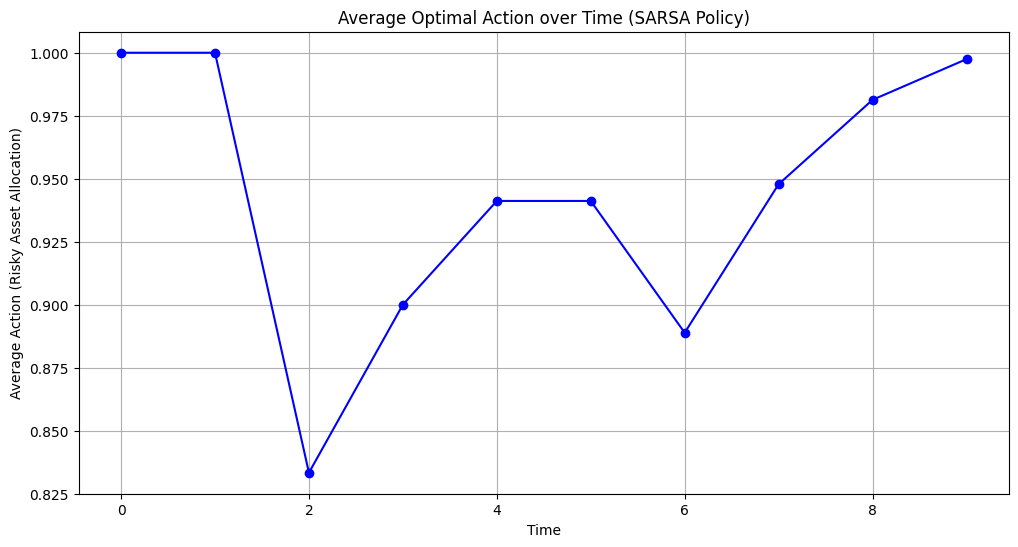

In [11]:
# 2.3 1000000次迭代

Q, policy = agent.train(episodes=1000000)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 1
Time 1:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 1
  Wealth 12.50: Best Action 0
Time 2:
  Wealth 10.00: Best Action 0
  Wealth 11.00: Best Action 1
  Wealth 12.10: Best Action 0
  Wealth 12.50: Best Action 0
  Wealth 13.75: Best Action 1
  Wealth 15.62: Best Action 0
Time 3:
  Wealth 10.00: Best Action 0
  Wealth 11.00: Best Action 0
  Wealth 12.10: Best Action 1
  Wealth 12.50: Best Action 0
  Wealth 13.31: Best Action 0
  Wealth 13.75: Best Action 1
  Wealth 15.12: Best Action 0
  Wealth 15.62: Best Action 0
  Wealth 17.19: Best Action 0
  Wealth 19.53: Best Action 0
Time 4:
  Wealth 10.00: Best Action 0
  Wealth 11.00: Best Action 0
  Wealth 12.10: Best Action 0
  Wealth 12.50: Best Action 0
  Wealth 13.31: Best Action 1
  Wealth 13.75: Best Action 0
  Wealth 14.64: Best Action 0
  Wealth 15.12: Best Action 1
  Wealth 15.62: Best Action 0
  Wealth 16.64: Best Action 0
  Wealth 17.19: Best Action 0
  Wealth 18.91: Best Action 0


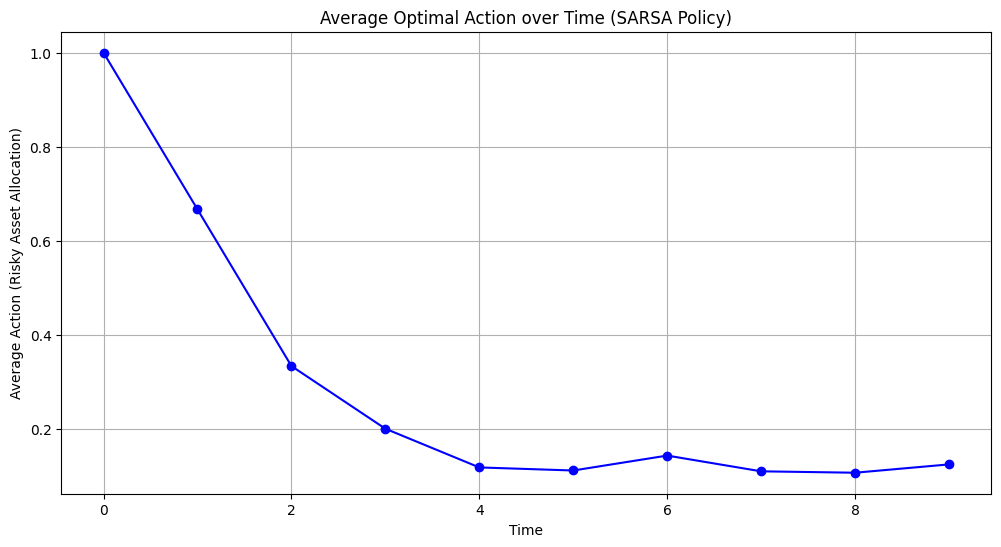

In [12]:
# 3.1 100次迭代

env = AssetEnv(initial_wealth=10, T=10, aversion_rate=0.01, riskless_return=0.1,
                  risky_return = {0.4: 0.25, 0.6: 0}, action_space=None)
agent = SARSAAgent(env)
Q, policy = agent.train(episodes=100)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 1
Time 1:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 1
  Wealth 12.50: Best Action 1
Time 2:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 0
  Wealth 12.10: Best Action 0
  Wealth 12.50: Best Action 0
  Wealth 13.75: Best Action 0
  Wealth 15.62: Best Action 1
Time 3:
  Wealth 10.00: Best Action 0
  Wealth 11.00: Best Action 0
  Wealth 12.10: Best Action 0
  Wealth 12.50: Best Action 1
  Wealth 13.31: Best Action 0
  Wealth 13.75: Best Action 1
  Wealth 15.12: Best Action 1
  Wealth 15.62: Best Action 1
  Wealth 17.19: Best Action 1
  Wealth 19.53: Best Action 1
Time 4:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 1
  Wealth 12.10: Best Action 0
  Wealth 12.50: Best Action 1
  Wealth 13.31: Best Action 0
  Wealth 13.75: Best Action 1
  Wealth 14.64: Best Action 1
  Wealth 15.12: Best Action 1
  Wealth 15.62: Best Action 1
  Wealth 16.64: Best Action 1
  Wealth 17.19: Best Action 1
  Wealth 18.91: Best Action 1


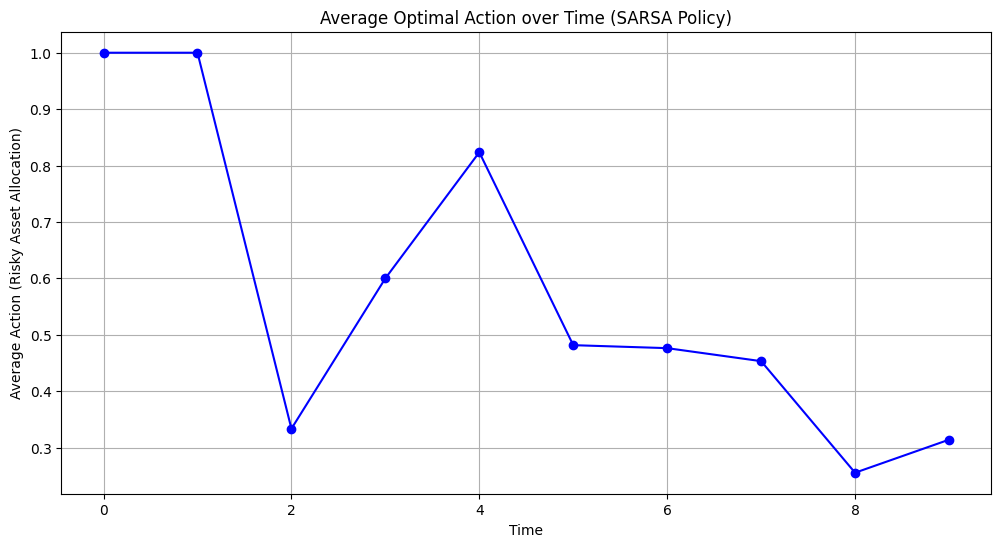

In [13]:
# 3.1 10000次迭代

Q, policy = agent.train(episodes=10000)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()

Time 0:
  Wealth 10.00: Best Action 1
Time 1:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 0
  Wealth 12.50: Best Action 1
Time 2:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 1
  Wealth 12.10: Best Action 1
  Wealth 12.50: Best Action 1
  Wealth 13.75: Best Action 0
  Wealth 15.62: Best Action 0
Time 3:
  Wealth 10.00: Best Action 0
  Wealth 11.00: Best Action 0
  Wealth 12.10: Best Action 1
  Wealth 12.50: Best Action 0
  Wealth 13.31: Best Action 0
  Wealth 13.75: Best Action 1
  Wealth 15.12: Best Action 1
  Wealth 15.62: Best Action 0
  Wealth 17.19: Best Action 0
  Wealth 19.53: Best Action 0
Time 4:
  Wealth 10.00: Best Action 1
  Wealth 11.00: Best Action 1
  Wealth 12.10: Best Action 0
  Wealth 12.50: Best Action 1
  Wealth 13.31: Best Action 0
  Wealth 13.75: Best Action 0
  Wealth 14.64: Best Action 1
  Wealth 15.12: Best Action 0
  Wealth 15.62: Best Action 1
  Wealth 16.64: Best Action 0
  Wealth 17.19: Best Action 0
  Wealth 18.91: Best Action 0


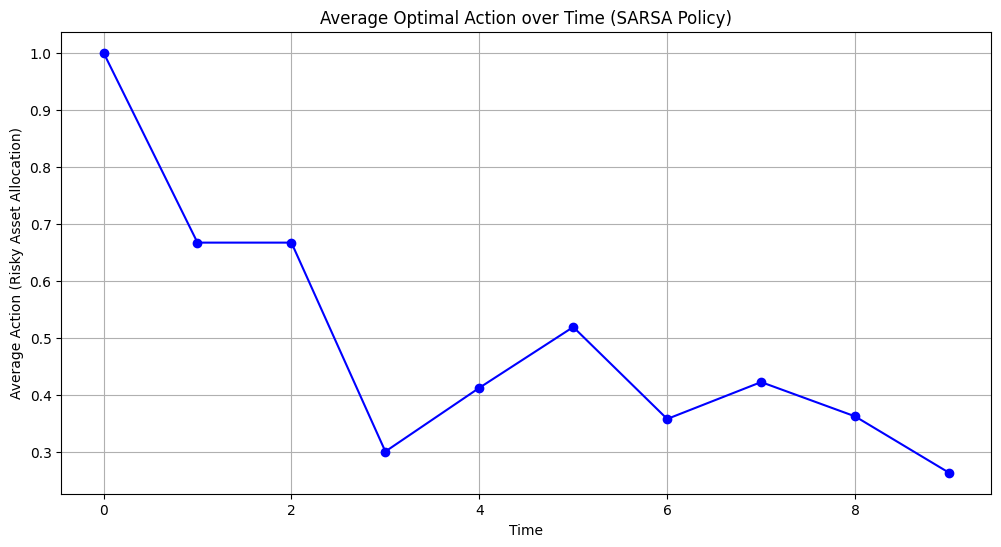

In [14]:
# 3.3 1000000次迭代的结果

Q, policy = agent.train(episodes=1000000)
# 输出最终策略示例
hist = []
for t in range(env.T):
    print(f"Time {t}:")
    for wealth in sorted(env.state_space[t]):
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        hist.append(best_action)
        print(f"  Wealth {wealth:.2f}: Best Action {best_action}")

# 计算每个时间步动作的平均值
action_distribution = {}
for t in range(env.T):
    actions_at_t = []
    for wealth in env.state_space[t]:
        best_action = max(policy[t][wealth], key=policy[t][wealth].get)
        actions = action_distribution.get(t, [])
        actions_at_t = actions + [best_action]
        action_distribution[t] = actions_at_t

# 计算每个时间步动作的平均
avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

# 绘制平均动作随时间变化的图表
plt.figure(figsize=(12, 6))
plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

plt.xlabel('Time')
plt.ylabel('Average Action (Risky Asset Allocation)')
plt.title('Average Optimal Action over Time (SARSA Policy)')
plt.grid(True)
plt.show()